1. Feature Engineering
Add:
  1. Popularity
  2. last review到2019年最后一天间隔天数

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data
from google.colab import files
files.upload()  # Upload the kaggle.json file

# Make sure kaggle.json is in the location ~/.kaggle/kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

# Unzip the dataset (if it's zipped)
!unzip new-york-city-airbnb-open-data.zip

# Now you can load the dataset
data = pd.read_csv('AB_NYC_2019.csv')

Saving AB_NYC_2019.csv to AB_NYC_2019 (2).csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
License(s): CC0-1.0
new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  new-york-city-airbnb-open-data.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: AB_NYC_2019.csv         
replace New_York_City_.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: New_York_City_.png      


In [ ]:
data = pd.read_csv('AB_NYC_2019.csv')

In [ ]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
# dataset information
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
# Add last review到2019年最后一天天数
data['days_to_last_review'] = pd.to_datetime('2019-12-31') - pd.to_datetime(data['last_review'])
data['days_to_last_review'] = data['days_to_last_review'].dt.days
data['days_to_last_review'][np.isnan(data['days_to_last_review'])] = data['days_to_last_review'].max() + 10000


<ipython-input-40-938e899be9e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_to_last_review'][np.isnan(data['days_to_last_review'])] = data['days_to_last_review'].max() + 10000


In [ ]:
# Add popularity: neighborhood with counts > 1000
neighborhood_counts = data['neighbourhood'].value_counts()
popular_neighbors = neighborhood_counts[neighborhood_counts > 1000].index
data['popularity'] = data['neighbourhood'].apply(lambda x: int(x in popular_neighbors))
data['popularity']

0        0
1        1
2        1
3        0
4        1
        ..
48890    1
48891    1
48892    1
48893    1
48894    1
Name: popularity, Length: 48895, dtype: int64

In [ ]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_to_last_review', 'popularity'],
      dtype='object')

In [ ]:
data = data.drop(columns=['id','host_id', 'last_review','latitude', 'longitude', 'name', 'host_name'])
cat_col = ['neighbourhood_group','room_type']


In [ ]:
data.fillna(0, inplace=True)
data = pd.get_dummies(data, columns=cat_col)

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X = data.drop(columns='price')
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=999)

# modify popularity for X train
neighborhood_counts_train = X_train['neighbourhood'].value_counts()
popular_neighbors_train = neighborhood_counts_train[neighborhood_counts_train > 1000*(1-test_size)].index
X_train['popularity'] = X_train['neighbourhood'].apply(lambda x: int(x in popular_neighbors_train))
X_train = X_train.drop(columns='neighbourhood')
X_test = X_test.drop(columns='neighbourhood')

Models:

1. Linear regression (Yuan Xu)
2. Decision Tree regression (Yue)
3. Random Forest regression feature importance (Yue)
4. Lasso regression  penalized features (Jennie)
5. Ridge regression penalized features (Jennie)
6. LSTM (Qi Wu)
7. extra free regressor (Yuan Xu)
8. KNN (Qi Wu)


In [ ]:
# LSTM
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

X_train = np.array(X_train)[:,:,np.newaxis]
X_test = np.array(X_test)[:,:,np.newaxis]
y_train[y_train>500] = 500
y_test[y_test>500] = 500

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


inputs = layers.Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
print(inputs.shape)
lstm = layers.LSTM(units=128, return_sequences=False)(inputs)
print(lstm.shape)
outputs = layers.Dense(max(y)+1, activation='softmax')(lstm)
print(outputs.shape)
lstm = keras.Model(inputs, outputs)

lstm.compile(optimizer=keras.optimizers.Adam(0.001),
             loss='mse',
             metrics=['mse', 'mae'],)
lstm.summary()

history = lstm.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

(None, 15, 1)
(None, 128)
(None, 10001)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 15, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 10001)             1290129   
                                                                 
Total params: 1356689 (5.18 MB)
Trainable params: 1356689 (5.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1101/1101 [==============================] - 54s 46ms/step - loss: 29804.1719 - mse: 29804.1719 - mae: 139.2580 - val_loss: 29638.0430 - val_mse: 29638.0430 - val_mae: 139.6541
Epoch 2/5
1101/1101 [==============================] - 56s

In [ ]:
y_pred = history.model.predict(X_test)
y_pred.shape

306/306 [==============================] - 5s 15ms/step


(9779, 10001)

In [ ]:
np.dot(y_pred, np.arange(max(y)+1))

array([4999.95823274, 5000.00700487, 4999.96685316, ..., 4999.99930627,
       4999.97666627, 4999.97391264])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error

def evaluate_model(predictions, y_true):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = mean_squared_error(y_true, predictions, squared=False)
    r2 = r2_score(y_true, predictions)
    return mae, mse, rmse, r2

for k in [5,6,7,8,9,10]: # 9 is the best
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  dt_metrics = evaluate_model(y_pred, y_test)

  print(f"KNN Metrics: n_neighbors = {k}")
  print("MAE:", dt_metrics[0])
  print("MSE:", dt_metrics[1])
  print("RMSE:", dt_metrics[2])
  print("R^2:", dt_metrics[3])

KNN Metrics: n_neighbors = 5
MAE: 94.54036200020451
MSE: 59199.39050209633
RMSE: 243.30924869822834
R^2: -0.06304457159021859
KNN Metrics: n_neighbors = 6
MAE: 93.24429900807854
MSE: 57508.09278953768
RMSE: 239.8084502046116
R^2: -0.03267390667239711
KNN Metrics: n_neighbors = 7
MAE: 92.23702394343564
MSE: 56676.78005764121
RMSE: 238.06885570700175
R^2: -0.017746008269370783
KNN Metrics: n_neighbors = 8
MAE: 91.53820687186828
MSE: 56089.199884638
RMSE: 236.83158548774276
R^2: -0.007194820022542681
KNN Metrics: n_neighbors = 9
MAE: 91.52684323550464
MSE: 55323.348188799624
RMSE: 235.20915838631714
R^2: 0.006557593321566246
KNN Metrics: n_neighbors = 10
MAE: 92.45410573678289
MSE: 55493.98873197668
RMSE: 235.57162123646532
R^2: 0.003493397869906101


In [ ]:
y_test

37431    130
35191     90
33915    125
16311    151
5407      45
        ... 
1203     350
30616    125
23213     50
48461    330
22076    139
Name: price, Length: 9779, dtype: int64

「YUE」

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split

file_path = 'AB_NYC_2019.csv'
data = pd.read_csv(file_path)

test_size = 0.2
X = data.drop(columns='price')
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=999)

# modify popularity for X train
neighborhood_counts_train = X_train['neighbourhood'].value_counts()
popular_neighbors_train = neighborhood_counts_train[neighborhood_counts_train > 1000*(1-test_size)].index
X_train['popularity'] = X_train['neighbourhood'].apply(lambda x: int(x in popular_neighbors_train))
X_train = X_train.drop(columns='neighbourhood')
X_test = X_test.drop(columns='neighbourhood')

# Add last review到2019年最后一天天数
data['last_review'] = pd.to_numeric(data['last_review'], errors='coerce')
data['days_to_last_review'] = pd.to_datetime('2019-12-31') - pd.to_datetime(data['last_review'])
data['days_to_last_review'] = data['days_to_last_review'].dt.days
data.loc[data['days_to_last_review'].isnull(), 'days_to_last_review'] = data['days_to_last_review'].max() + 10000


# Add popularity: neighborhood with counts > 1000
neighborhood_counts = data['neighbourhood'].value_counts()
popular_neighbors = neighborhood_counts[neighborhood_counts > 1000].index
data['Popularity'] = data['neighbourhood'].apply(lambda x: int(x in popular_neighbors))

features =  ['latitude', 'longitude', 'minimum_nights', 'availability_365', 'Popularity', 'days_to_last_review']

# Calculate the 10th and 90th percentiles of the price
p10 = data['price'].quantile(0.1)
p90 = data['price'].quantile(0.9)

# Calculate the median of the bottom 10% and top 10% prices
median_bottom_10 = data[data['price'] <= p10]['price'].median()
median_top_10 = data[data['price'] >= p90]['price'].median()

# Update the prices
data.loc[data['price'] <= p10, 'price'] = median_bottom_10
data.loc[data['price'] >= p90, 'price'] = median_top_10

# Print or display a summary to verify changes
print(f"Updated 10% lowest prices to median: {median_bottom_10}")
print(f"Updated 10% highest prices to median: {median_top_10}")

target = 'price'
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


dt_model = DecisionTreeRegressor(max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features=None, criterion='friedman_mse')

dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)


# calculate value
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_predictions)

print()
print("Decision Tree Regression:")
print("MAE:", dt_mae)
print("MSE:", dt_mse)
print("RMSE:", dt_rmse)
print("R^2:", dt_r2)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# calculate
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

print()
print("Random Forest Regression:")
print("MAE:", rf_mae)
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("R^2:", rf_r2)

import matplotlib.pyplot as plt


# Decision Tree Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_predictions, color='blue', label='Actual vs Predicted (Decision Tree)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Decision Tree Regression)')
plt.legend()
plt.show()



# Random Forest Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, color='green', label='Actual vs Predicted (Random Forest)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Random Forest Regression)')
plt.legend()
plt.show()



### Jennie

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [ ]:
# load data
from google.colab import files
files.upload()  # Upload the kaggle.json file

# Make sure kaggle.json is in the location ~/.kaggle/kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

# Unzip the dataset (if it's zipped)
!unzip new-york-city-airbnb-open-data.zip

# Now you can load the dataset
df = pd.read_csv('AB_NYC_2019.csv')

In [ ]:
# Calculate the 10th and 90th percentiles of the price
p10 = df['price'].quantile(0.1)
p90 = df['price'].quantile(0.9)

# Calculate the median of the bottom 10% and top 10% prices
median_bottom_10 = df[df['price'] <= p10]['price'].median()
median_top_10 = df[df['price'] >= p90]['price'].median()

# Update the prices
df.loc[df['price'] <= p10, 'price'] = median_bottom_10
df.loc[df['price'] >= p90, 'price'] = median_top_10

# Optionally, save the modified dataset
# df.to_csv('C:/Users/Cheny/Desktop/AB_NYC_2019.csv', index=False)

# Print or display a summary to verify changes
print(f"Updated 10% lowest prices to median: {median_bottom_10}")
print(f"Updated 10% highest prices to median: {median_top_10}")

Updated 10% lowest prices to median: 40.0
Updated 10% highest prices to median: 352.0


In [ ]:
# Calculate the 10th and 90th percentiles of the price
p10 = df['price'].quantile(0.1)
p90 = df['price'].quantile(0.9)

# Update the prices in the dataset
# Prices less than or equal to the 10th percentile are set to the 10th percentile value
df.loc[df['price'] <= p10, 'price'] = p10
# Prices greater than or equal to the 90th percentile are set to the 90th percentile value
df.loc[df['price'] >= p90, 'price'] = p90

# Optionally, save the modified dataset
# df.to_csv('C:/Users/Cheny/Desktop/AB_NYC_2019.csv', index=False)

# Print or display a summary to verify changes
print(f"Updated 10% lowest prices to 10th percentile value: {p10}")
print(f"Updated 10% highest prices to 90th percentile value: {p90}")

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,review_year
132,30031,NYC artists’ loft with roof deck,129352,Sol,Brooklyn,Greenpoint,40.73494,-73.95030,Private room,50,3,193,2019-05-20,1.86,1,0,2019
165,41348,* Spacious GARDEN Park Slope Duplex* 6 people max,180083,Syl,Brooklyn,Gowanus,40.66858,-73.99083,Entire home/apt,250,2,80,2019-07-06,2.17,1,0,2019
174,44221,Financial District Luxury Loft,193722,Coral,Manhattan,Financial District,40.70666,-74.01374,Entire home/apt,196,3,114,2019-06-20,1.06,1,0,2019
180,45556,"Fort Greene, Brooklyn: Center Bedroom",67778,Doug,Brooklyn,Fort Greene,40.68863,-73.97691,Private room,65,2,206,2019-06-30,1.92,2,0,2019
197,53137,"Quiet, sunny Midtown Manhattan apt.",240360,Marlaine,Manhattan,Hell's Kitchen,40.76244,-73.99271,Entire home/apt,195,5,10,2019-07-01,1.01,1,0,2019


In [ ]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,review_year
count,3.445000e+04,3.445000e+04,34450.000000,34450.000000,34450.000000,34450.000000,34450.000000,29243,34450.000000,34450.000000,34450.000000,34450.000000
mean,2.113167e+07,7.983464e+07,40.728255,-73.949403,140.478258,7.966212,30.797533,2019-03-22 12:36:21.937557760,1.480379,9.564296,160.070914,1713.647402
min,2.539000e+03,2.571000e+03,40.499790,-74.244420,40.000000,1.000000,0.000000,2011-04-25 00:00:00,0.000000,1.000000,0.000000,0.000000
25%,1.216791e+07,8.481125e+06,40.688633,-73.983190,70.000000,2.000000,2.000000,2019-04-18 00:00:00,0.200000,1.000000,32.000000,2018.000000
50%,2.284311e+07,3.993048e+07,40.723200,-73.954330,110.000000,3.000000,10.000000,2019-06-13 00:00:00,0.880000,1.000000,141.000000,2019.000000
75%,3.104453e+07,1.400573e+08,40.762887,-73.931263,184.000000,5.000000,37.000000,2019-06-27 00:00:00,2.260000,3.000000,292.000000,2019.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,352.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000,2019.000000
std,1.133844e+07,8.579000e+07,0.056094,0.050391,93.424799,22.952423,50.446386,NaN,1.747427,38.933375,130.456585,723.120642


In [ ]:
top_10_percent = df[df['price'] >= p90]
print(top_10_percent)

             id                                               name    host_id  \
501      177495   PRIME, Luxury, Spacious 2 Bedroom Apt in Chelsea     848960   
621      235552                 HUGE Sunny Duplex Loft with Garden    1234405   
657      250259                          Pre-War Williamsburg Loft    1311398   
805      287417                 HOT SPOT FOR 20 AND 30 SOMETHING'S    1495196   
890      322037                 Luxury Williamsburg, Brooklyn LOFT    1649300   
...         ...                                                ...        ...   
48758  36420289    Rustic Garden House Apt, 2 stops from Manhattan   73211393   
48833  36450896   Brand New 3-Bed Apt in the Best Location of FiDi   29741813   
48839  36452721  Massage Spa. Stay overnight. Authors Artist dr...  274079964   
48842  36453160  LUXURY MANHATTAN PENTHOUSE+HUDSON RIVER+EMPIRE...  224171371   
48856  36457700  Large 3 bed, 2 bath , garden , bbq , all you need   66993395   

                     host_n

In [ ]:
# Add last review到2019年最后一天天数
df['days_to_last_review'] = pd.to_datetime('2019-12-31') - pd.to_datetime(df['last_review'])
df['days_to_last_review'] = df['days_to_last_review'].dt.days
df['days_to_last_review'][np.isnan(data['days_to_last_review'])] = df['days_to_last_review'].max() + 10000

<ipython-input-26-f4d99023b0ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_to_last_review'][np.isnan(data['days_to_last_review'])] = df['days_to_last_review'].max() + 10000


In [ ]:
# Add popularity: neighborhood with counts > 1000
neighborhood_counts = df['neighbourhood'].value_counts()
popular_neighbors = neighborhood_counts[neighborhood_counts > 1000].index
df['popularity'] = df['neighbourhood'].apply(lambda x: int(x in popular_neighbors))
df['popularity']

132      0
165      0
174      0
180      0
197      1
        ..
48890    1
48891    1
48892    1
48893    1
48894    1
Name: popularity, Length: 34450, dtype: int64

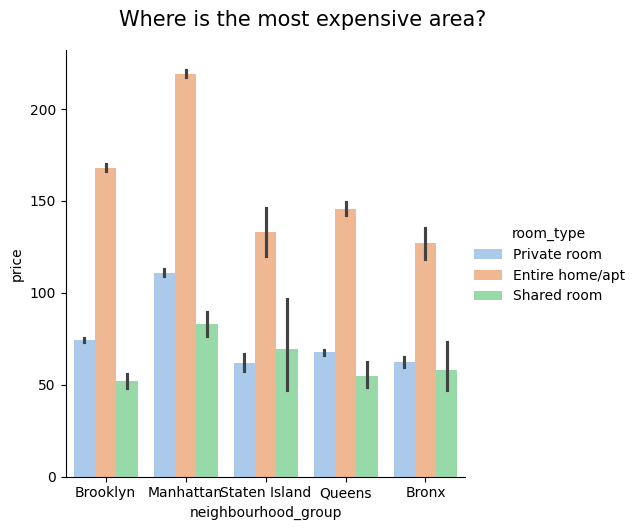

In [ ]:
# Price according to different room_type in different areas
fig2 = sns.catplot(x='neighbourhood_group',y='price',data=df,kind='bar',hue='room_type',palette='pastel')
fig2.fig.suptitle('Where is the most expensive area?',fontsize=15,y=1.05)
fig2.savefig('price_area.png', bbox_inches = 'tight')

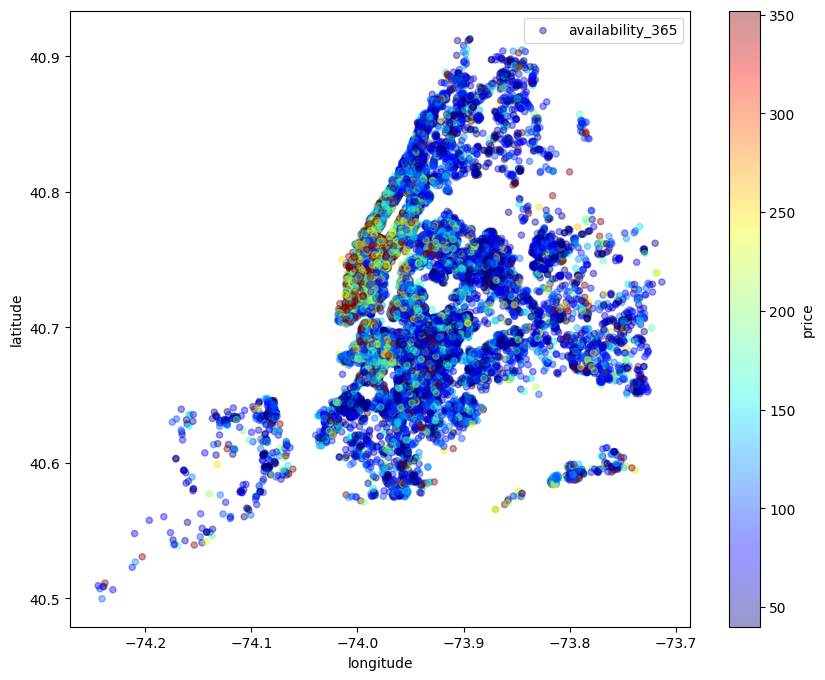

In [ ]:
fig3 = df[df.price < 500].plot(kind='scatter', x='longitude', y='latitude', label='availability_365',
                 c='price', cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))
fig3.legend()

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'api'

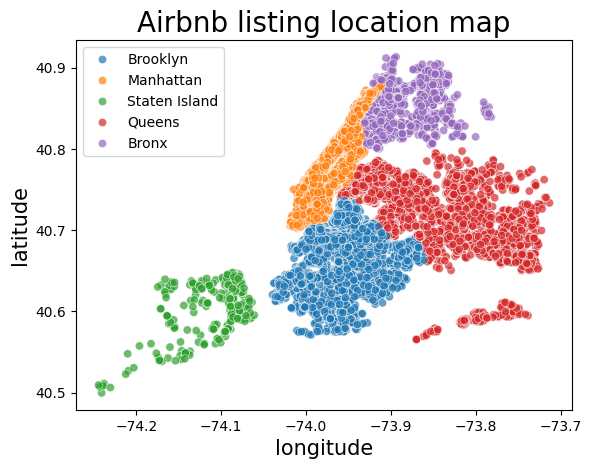

In [ ]:
# fig1,ax1=plt.subplots(figsize=(16,9))
ax=sns.scatterplot(x='longitude',y='latitude',hue='neighbourhood_group',data=df,alpha=0.7)
ax.set_title('Airbnb listing location map',fontsize=20)
ax.set_xlabel('longitude',fontsize=15)
ax.set_ylabel('latitude',fontsize=15)
plt.legend(loc='best')
plt.savefig('location.png', bbox_inches = 'tight', api=384)

In [ ]:
import pandas as pd

def dataloader(df, cols, dummy_na):
    # 初始化一个空列表来收集每个分类列的虚拟变量DataFrame
    data = []
    for col in cols:
        try:
            # 生成当前列的虚拟变量
            dummy = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)
            data.append(dummy)
        except KeyError:
            # print(f"Warning: The column '{col}' does not exist in the DataFrame.")
            continue

    # 将原始数据框中的分类列删除（如果它们存在）
    df = df.drop(columns=[col for col in cols if col in df.columns])
    # 将所有虚拟变量的数据框与原始数据框合并
    df = pd.concat([df] + data, axis=1)
    return df


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

class Model:
    def __init__(self, df, response_col, cat_cols, dummy_na, model, test_size=.3, rand_state=22):
        self.df = df
        self.response_col = response_col
        self.cat_cols = cat_cols
        self.dummy_na = dummy_na
        self.model = model
        self.test_size = test_size
        self.rand_state = rand_state

    def preprocess(self):
        self.df = self.df.dropna(subset=[self.response_col], axis=0)
        self.df = self.df.dropna(how='all', axis=1)
        self.df = dataloader(self.df, self.cat_cols, self.dummy_na)
        X = self.df.drop(self.response_col, axis=1)
        y = self.df[self.response_col]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.rand_state)

    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        self.y_test_preds = self.model.predict(self.X_test)
        self.y_train_preds = self.model.predict(self.X_train)

    def evaluate(self):
        test_mse = mean_squared_error(self.y_test, self.y_test_preds)
        train_mse = mean_squared_error(self.y_train, self.y_train_preds)
        test_r2 = r2_score(self.y_test, self.y_test_preds)
        train_r2 = r2_score(self.y_train, self.y_train_preds)
        return test_mse, train_mse, test_r2, train_r2

    def run(self):
        self.preprocess()
        self.train()
        self.predict()
        return self.evaluate()


In [ ]:
df = df.drop(columns=['id','host_id', 'last_review','latitude', 'longitude', 'name', 'host_name'])
cat_col = ['neighbourhood_group','room_type']


In [ ]:
df.fillna(0, inplace=True)
df = pd.get_dummies(df, columns=cat_col)

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=999)

# modify popularity for X train
neighborhood_counts_train = X_train['neighbourhood'].value_counts()
popular_neighbors_train = neighborhood_counts_train[neighborhood_counts_train > 1000*(1-test_size)].index
X_train['popularity'] = X_train['neighbourhood'].apply(lambda x: int(x in popular_neighbors_train))
X_train = X_train.drop(columns='neighbourhood')
X_test = X_test.drop(columns='neighbourhood')

In [ ]:
cat_df = df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns
# all categorical variables have no missing values, so set dummy_na=False
df_new = dataloader(df, cat_cols_lst, dummy_na=False)

Running model: model_bayesian
Test R2: 0.4799766283237693
Train R2: 0.4963058041937737
Test MSE: 4456.8139731936835
Train MSE: 4430.20128426752


Running model: Ridge
Test R2: 0.47834280907699944
Train R2: 0.4977736013660867
Test MSE: 4470.816475475851
Train MSE: 4417.291393758624


Running model: Lasso
Test R2: 0.47653060878711473
Train R2: 0.4868400881163413
Test MSE: 4486.347776594394
Train MSE: 4513.456219249709




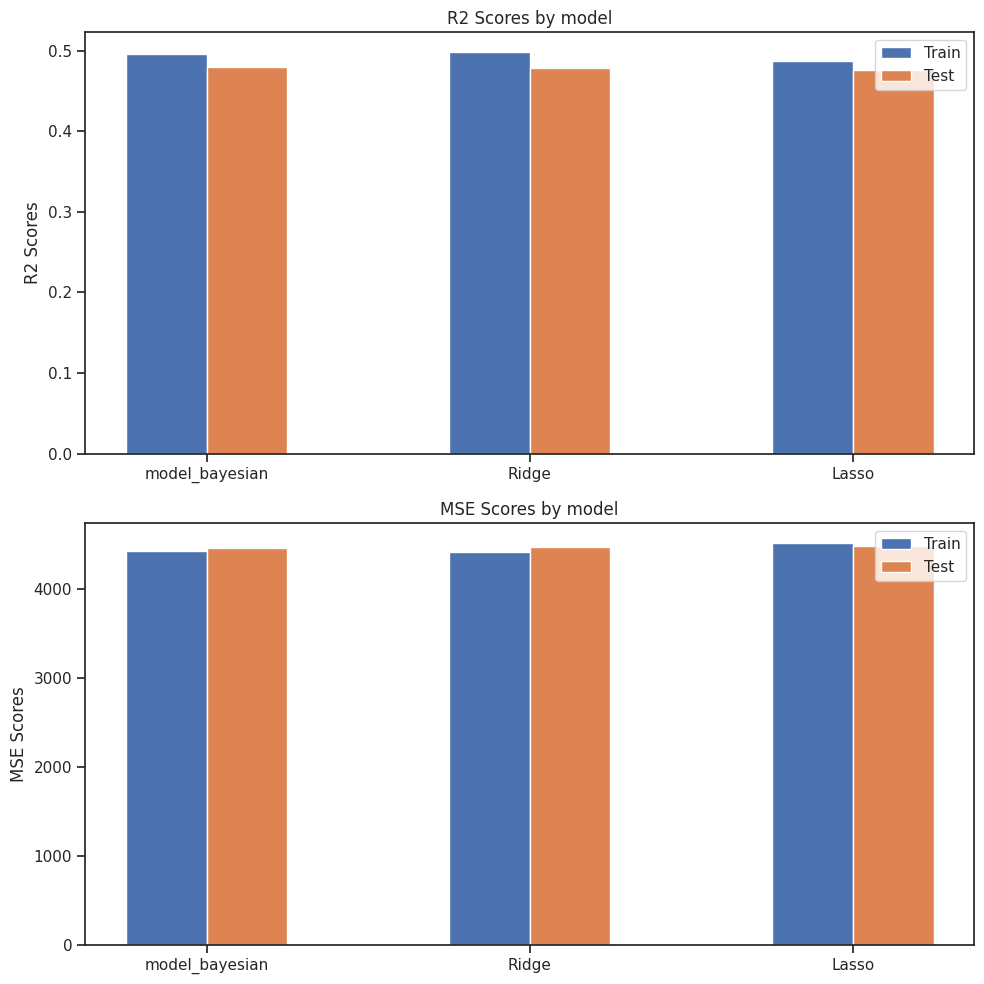

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn
seaborn.set(style='ticks')
def run_models(df, response_col, cat_cols, dummy_na=False):
    models = [
        ('model_bayesian', BayesianRidge()),
        ('Ridge', Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge())
        ])),
        ('Lasso', Pipeline([
            ('scaler', StandardScaler()),
            ('lasso', Lasso())
        ]))



    ]

    train_r2s = []
    train_mses = []
    test_r2s = []
    test_mses = []

    for name, model in models:
        print(f"Running model: {name}")
        model_instance = Model(df, response_col, cat_cols, dummy_na, model)
        test_mse, train_mse, test_r2, train_r2 = model_instance.run()
        print(f"Test R2: {test_r2}")
        print(f"Train R2: {train_r2}")
        print(f"Test MSE: {test_mse}")
        print(f"Train MSE: {train_mse}")
        print("\n")

        train_r2s.append(train_r2)
        train_mses.append(train_mse)
        test_r2s.append(test_r2)
        test_mses.append(test_mse)

    # 绘制指标对比图，三个模型放在一个图里
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    x = np.arange(len(models))
    width = 0.25

    ax[0].bar(x - width/2, train_r2s, width, label='Train')
    ax[0].bar(x + width/2, test_r2s, width, label='Test')
    ax[0].set_ylabel('R2 Scores')
    ax[0].set_title('R2 Scores by model')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels([name for name, _ in models])
    ax[0].legend()

    ax[1].bar(x - width/2, train_mses, width, label='Train')
    ax[1].bar(x + width/2, test_mses, width, label='Test')
    ax[1].set_ylabel('MSE Scores')
    ax[1].set_title('MSE Scores by model')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels([name for name, _ in models])
    ax[1].legend()

    plt.tight_layout()
    plt.show()

run_models(df, 'price', cat_cols_lst)

Running model: model_bayesian
Test R2: 0.4799766283237693
Train R2: 0.4963058041937737
Test MSE: 4456.8139731936835
Train MSE: 4430.20128426752


Running model: Ridge
Test R2: 0.47834280907699944
Train R2: 0.4977736013660867
Test MSE: 4470.816475475851
Train MSE: 4417.291393758624


Running model: Lasso
Test R2: 0.47653060878711473
Train R2: 0.4868400881163413
Test MSE: 4486.347776594394
Train MSE: 4513.456219249709


Running model: Elastic
Test R2: 0.31687492658673266
Train R2: 0.3194065667872501
Test MSE: 5854.662575671255
Train MSE: 5986.104122278024




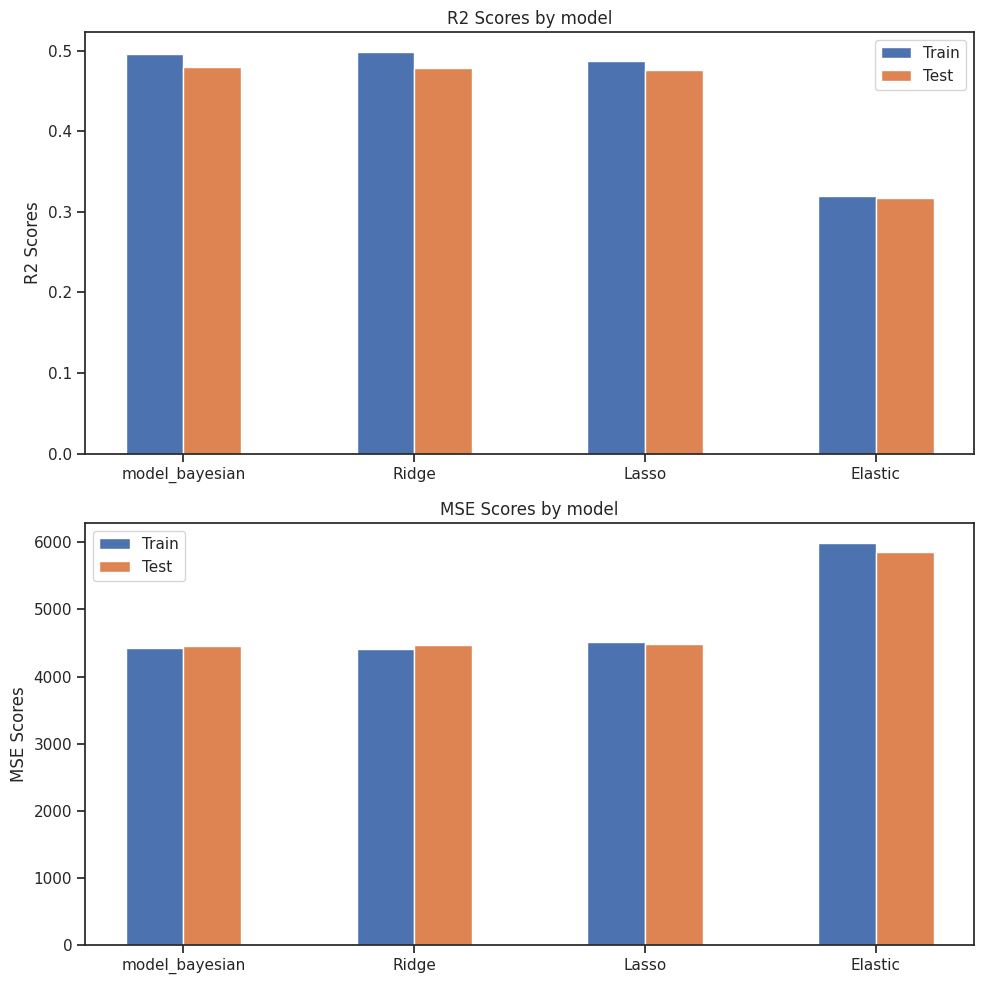

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import seaborn

seaborn.set(style='ticks')

def run_models(df, response_col, cat_cols, dummy_na=False):
    models = [
        ('model_bayesian', BayesianRidge()),
        ('Ridge', Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge())
        ])),
        ('Lasso', Pipeline([
            ('scaler', StandardScaler()),
            ('lasso', Lasso())
        ])),  # Added the missing comma here
        ('Elastic', ElasticNet(alpha=1.0, l1_ratio=0.5))

    ]

    train_r2s = []
    train_mses = []
    test_r2s = []
    test_mses = []

    for name, model in models:
        print(f"Running model: {name}")
        model_instance = Model(df, response_col, cat_cols, dummy_na, model)
        test_mse, train_mse, test_r2, train_r2 = model_instance.run()
        print(f"Test R2: {test_r2}")
        print(f"Train R2: {train_r2}")
        print(f"Test MSE: {test_mse}")
        print(f"Train MSE: {train_mse}")
        print("\n")

        train_r2s.append(train_r2)
        train_mses.append(train_mse)
        test_r2s.append(test_r2)
        test_mses.append(test_mse)

    # Plotting the metrics comparison, all models in one plot
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    x = np.arange(len(models))
    width = 0.25

    ax[0].bar(x - width/2, train_r2s, width, label='Train')
    ax[0].bar(x + width/2, test_r2s, width, label='Test')
    ax[0].set_ylabel('R2 Scores')
    ax[0].set_title('R2 Scores by model')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels([name for name, _ in models])
    ax[0].legend()

    ax[1].bar(x - width/2, train_mses, width, label='Train')
    ax[1].bar(x + width/2, test_mses, width, label='Test')
    ax[1].set_ylabel('MSE Scores')
    ax[1].set_title('MSE Scores by model')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels([name for name, _ in models])
    ax[1].legend()

    plt.tight_layout()
    plt.show()
run_models(df, 'price', cat_cols_lst)